# Fixed Bias $R_{t}$ analysis

Analysis of results for a model with a fixed reporting bias based on a dirichlet prior, as well as an unknown, time-varying Rt value.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from periodic_sampling.synthetic_data import RenewalModel, Reporter

In [112]:
# Read in dataset

output = pd.read_csv("stan_inference_T_scale_100_N0_100_R0diff_0.2_It_100000_seed_41.csv")
time_steps = 100; N_0 = 100; step_num=100; seed=41; R0_diff = 0.2; start_date = '01/01/2020'; bias_method = 'scale'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))

np.random.seed(seed); model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease
truth_df = rep.unbiased_report(); bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

images_path = "synthetic_inference/stepped_R/multichain/variable_sampling_rate/"

100%|██████████| 100/100 [00:00<00:00, 153132.68it/s]


In [113]:
def rename_col(col):
    col = col.replace('.', '_')
    return col[:5] + str(int(col[5:])-1) if col.startswith('bias') else col

output.columns = map(rename_col, output.columns)  # Only run this once!

Bias_0: 0.55 +/- 0.0
Bias_1: 1.48 +/- 0.01
Bias_2: 1.23 +/- 0.01
Bias_3: 1.04 +/- 0.01
Bias_4: 1.06 +/- 0.01
Bias_5: 1.01 +/- 0.01
Bias_6: 0.63 +/- 0.0


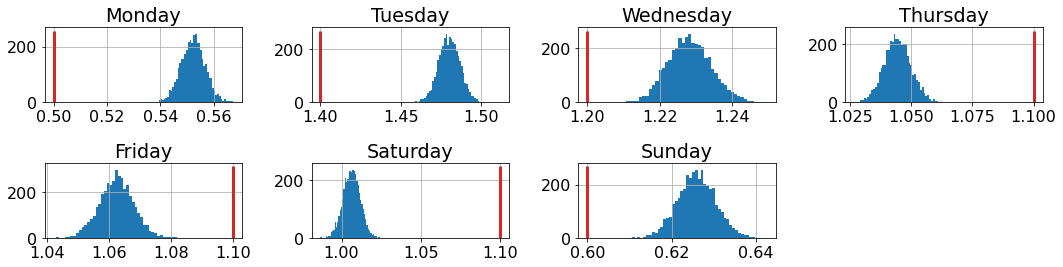

In [119]:
plt.rcParams['font.size'] = '16'

start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday() - 1
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=50, figsize=(15, 4), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig(f"biases_only_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seeds_{seed}.png")

for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 2)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 2)
    print(f"Bias_{i}: {mean} +/- {std}")

In [115]:
print(start_index)

1


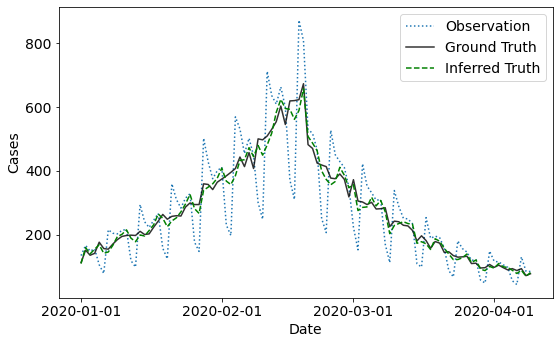

In [129]:
predicted_truth = [bias_df['Confirmed'][i] / np.mean(output['bias_' + str(int((i - 6) % 7))])
                   for i in range(0, time_steps)]  

# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
axs.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
axs.set_xticks(axs.get_xticks()[::2]);
plt.xlabel("Date"); plt.ylabel("Cases");
plt.legend();  plt.tight_layout()
# plt.savefig(f"partial_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

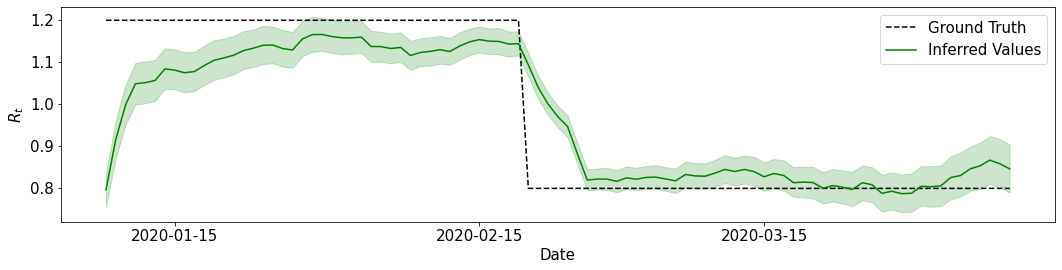

In [124]:
plt.rcParams['font.size'] = '15'; interval_range = 90
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


for index in range(1, time_steps+1):
    predicted_R.append(np.mean(output['R_' + str(index)]))
    upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
    lower_R.append(np.percentile(output['R_' + str(index)], percentile))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(15, 4))

ax.plot(truth_df['Date'][7:], R0_list[7:], color='black', label = 'Ground Truth', linestyle = 'dashed')
ax.plot(truth_df['Date'][7:], predicted_R[7:], color='green', label = 'Inferred Values')
ax.fill_between(truth_df['Date'][7:], lower_R[7:], upper_R[7:], color = 'green', alpha=0.2)

ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("$R_{t}$")
plt.legend(); plt.tight_layout()
# plt.savefig(f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

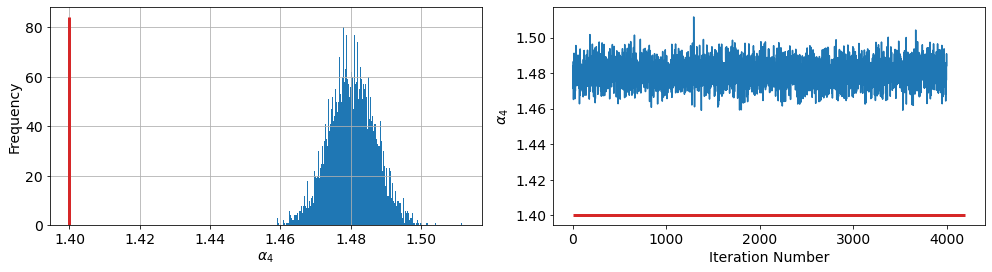

In [125]:
i = 0; bias_x = 'bias_' + str(i)
value = 1.4; bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"{bias_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")